Canvas(height=750, width=750)

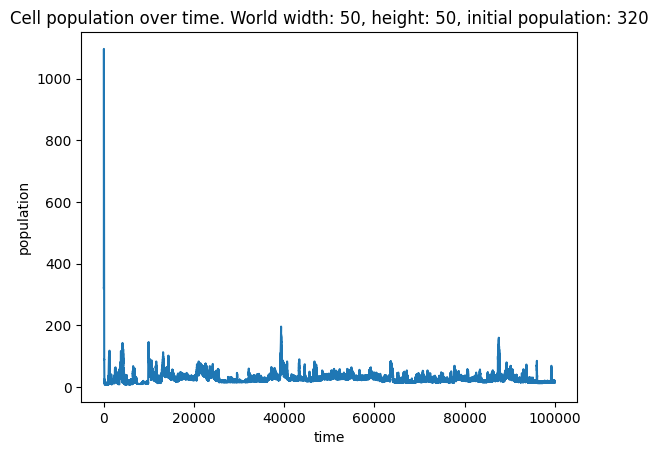

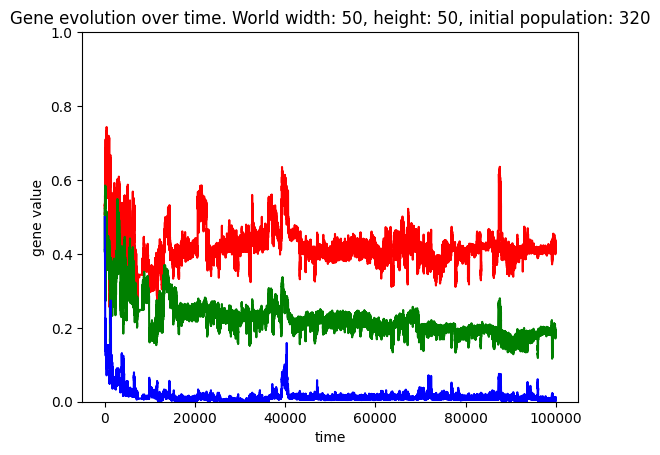

In [56]:
from ipycanvas import Canvas, hold_canvas
from Klasser.celle import *
from Klasser.busk import *
import random
from time import sleep
from matplotlib import pyplot as plt

background_color = "#EEEEEE"

# visual size of tiles
tile_size = 15
visual_space = 2
rect_size = tile_size - visual_space

# change size of world and proportionally its inhabitants
scale = 2

# amount of tiles in each direction
tiles_hori = 25 * scale
tiles_vert = 25 * scale

start_antal_celler = 80 * scale**2
start_energi = 30 * scale**2

antal_busker = 20

# Contains objects inhabiting the world
entities = []

# capture data for plotting
time = 0
time_list = []
population = []

# Create empty world, to contain references to cells
verd = []
for x in range(tiles_hori):
    row = []
    for y in range(tiles_vert):
        row.append(None)
    verd.append(row)

def get_nabolag(pos_x, pos_y, radius):
    nabolag = []
    nabolag_rad = []
    for y in range(pos_y - radius, pos_y + radius + 1):
        for x in range(pos_x - radius, pos_x + radius + 1):
            nabolag_rad.append(verd[x % tiles_hori][y % tiles_vert])
        nabolag.append(nabolag_rad)
        nabolag_rad = []
    return nabolag

def fjern_celle(celle):
    index = entities.index(celle)
    i = index
    while i < len(entities) - 1:
        i += 1
        verd[entities[i].pos_x][entities[i].pos_y] -= 1
    verd[celle.pos_x][celle.pos_y] = None
    entities.pop(index)

def skap_celle(celle_1, celle_2):
    x = celle_1.pos_x + random.randint(-1, 1)
    y = celle_1.pos_y + random.randint(-1, 1)
    position_checks = 0
    while verd[x % tiles_hori][y % tiles_vert] != None:
        position_checks += 1
        if position_checks == 9:
            return
        x = celle_1.pos_x + random.randint(-1, 1)
        y = celle_1.pos_y + random.randint(-1, 1)
    energi = int(celle_1.energi*celle_1.gen_energi_overføring + celle_2.energi*celle_2.gen_energi_overføring)
    celle_1.energi -= int(celle_1.energi*celle_1.gen_energi_overføring)
    celle_2.energi -= int(celle_2.energi*celle_2.gen_energi_overføring)
    gen_mål_ønske = (celle_1.gen_mål_ønske + celle_2.gen_mål_ønske)/2 + (random.random() - 0.5)*0.1
    if gen_mål_ønske < 0:
        gen_mål_ønske = 0
    elif gen_mål_ønske > 1:
        gen_mål_ønske = 1
    gen_syn_og_energi_effektivitet = (celle_1.gen_syn_og_energi_effektivitet + celle_2.gen_syn_og_energi_effektivitet)/2 + (random.random() - 0.5)*0.1
    if gen_syn_og_energi_effektivitet < 0:
        gen_syn_og_energi_effektivitet = 0
    elif gen_syn_og_energi_effektivitet > 1:
        gen_syn_og_energi_effektivitet = 1
    gen_energi_overføring = (celle_1.gen_energi_overføring + celle_2.gen_energi_overføring)/2 + (random.random() - 0.5)*0.1
    if gen_energi_overføring < 0:
        gen_energi_overføring = 0
    elif gen_energi_overføring > 1:
        gen_energi_overføring = 1
    ny_celle = Celle(x % tiles_hori, y % tiles_vert, energi, tiles_hori, tiles_vert, gen_mål_ønske, gen_syn_og_energi_effektivitet, gen_energi_overføring, skap_celle)
    entities.append(ny_celle)
    verd[x % tiles_hori][y % tiles_vert] = len(entities) - 1

    # Cell needs to have a valid target at birth
    nabolag = get_nabolag(ny_celle.pos_x, ny_celle.pos_y, ny_celle.sight_range)
    ny_celle.finn_mål(nabolag, entities)


# Populate world
celler_igjen = start_antal_celler
busker_igjen = antal_busker
while celler_igjen > 0 or busker_igjen > 0:
    x = random.randint(0, tiles_hori - 1)
    y = random.randint(0, tiles_vert - 1)
    while verd[x][y] != None:
        x = random.randint(0, tiles_hori - 1)
        y = random.randint(0, tiles_vert - 1)
    if celler_igjen > 0:
        sight_range = random.randint(1, 4)
        gen_mål_ønske = random.random()
        gen_syn_og_energi_effektivitet = random.random()
        gen_energi_overføring = random.random()
        new_cell = Celle(x, y, start_energi, tiles_hori, tiles_vert, gen_mål_ønske, gen_syn_og_energi_effektivitet, gen_energi_overføring, skap_celle)
        entities.append(new_cell)
        verd[x][y] = len(entities) - 1
        celler_igjen -= 1
    else:
        new_busk = Busk(x, y, 0, 5)
        entities.append(new_busk)
        verd[x][y] = len(entities) - 1
        busker_igjen -= 1


# Canvas size
width = tile_size * tiles_hori
height = tile_size * tiles_vert

canvas = Canvas(height = height, width = width)
display(canvas)
vision_canvas = Canvas(height = height, width = width)
#display(vision_canvas)

def draw_world(canvas):
    # Draw grid
    canvas.fill_style = background_color
    for x in range(tiles_hori):
        for y in range(tiles_vert):
            canvas.fill_rect(x * tile_size, y * tile_size, rect_size, rect_size)

def draw_entities(world, _canvas):
    with hold_canvas():
        x = 0
        for col in world:
            y = 0
            for tile in col:
                _canvas.fill_style = background_color
                if tile != None:
                    content = entities[tile]
                    if type(content) == Busk:
                        _canvas.fill_style = "green"
                    elif type(content) == Celle:
                        _canvas.fill_style = "blue"
                _canvas.fill_rect(x * tile_size, y * tile_size, rect_size, rect_size)
                y += 1
            x += 1

def rollover(list, index, radius):
    if index - radius < 0 or index + radius >= len(list) - 1:
        return list[index - radius:] + list[:(index + radius + 1) % len(list)]
    else:
        return list[index - radius : index + radius + 1]


def draw_nabolag(nabolag, entity):
    with hold_canvas():
        x = 0
        for col in nabolag:
            y = 0
            for tile in col:
                vision_canvas.fill_style = background_color
                if tile != None:
                    content = entities[tile]
                    if type(content) == Busk:
                        vision_canvas.fill_style = "green"
                    elif type(content) == Celle:
                        vision_canvas.fill_style = "blue"
                vision_canvas.fill_rect(y * tile_size, x * tile_size, rect_size, rect_size)
                y += 1
            x += 1
        vision_canvas.fill_style = "tomato"
        vision_canvas.fill_rect(entity.mål_x * tile_size, entity.mål_y * tile_size, rect_size, rect_size)

gen_1_snitt_liste =[]
gen_2_snitt_liste = []
gen_3_snitt_liste = []

#Løkke som repeterast til programmet er ferdig
try:
    while time < 100_000:
        time_list.append(time)
        time += 1

        døande = []
        cell_count = 0
        for i in range(len(entities)):
            entity = entities[i]
            if type(entity) == Busk:
                entity.veks()
            elif type(entity) == Celle:
                cell_count += 1
                nabolag = get_nabolag(entity.pos_x, entity.pos_y, entity.sight_range)
                entity.finn_mål(nabolag, entities)
                #draw_nabolag(nabolag, entity)
                beveg_x, beveg_y, dir_x, dir_y = entity.beveg()
                # Move the cell towards its target if there isnt anything in the way
                move_target = verd[beveg_x % tiles_hori][beveg_y % tiles_vert]
                if move_target == None:
                    verd[entity.pos_x][entity.pos_y] = None
                    entity.update_pos(beveg_x % tiles_hori, beveg_y % tiles_vert, dir_x, dir_y)
                    verd[beveg_x % tiles_hori][beveg_y % tiles_vert] = i
                elif move_target == i:
                    pass
                else:
                    entity.har_mål = False
                entity.energi -= 1
                if entity.energi <= 0:
                    døande.append(entity)
        population.append(cell_count)
        for entity in døande:
            fjern_celle(entity)
        
        antal_celler = 0
        gen_1_sum = 0
        gen_2_sum = 0
        gen_3_sum = 0
        for entity in entities:
            if type(entity) == Celle:
                antal_celler += 1
                gen_1_sum += entity.gen_mål_ønske
                gen_2_sum += entity.gen_syn_og_energi_effektivitet
                gen_3_sum += entity.gen_energi_overføring
        gen_1_snitt = gen_1_sum/antal_celler
        gen_2_snitt = gen_2_sum/antal_celler
        gen_3_snitt = gen_3_sum/antal_celler
        gen_1_snitt_liste.append(gen_1_snitt)
        gen_2_snitt_liste.append(gen_2_snitt)
        gen_3_snitt_liste.append(gen_3_snitt)

        # Draw everything
        if time % 100 == 0:
            with hold_canvas():
                draw_world(canvas)
                for entity in entities:
                    entity.tegn(canvas, tile_size, rect_size)
                    if type(entity) == Celle:
                        nabolag = get_nabolag(entity.pos_x, entity.pos_y, entity.sight_range)
                        #draw_nabolag(nabolag, entity)
        
        if cell_count <= 5:
            break
        #sleep(0.001)
        #input("press enter to continue") # for stepping single frames
except KeyboardInterrupt:
    pass

plt.plot(time_list, population)
plt.xlabel("time")
plt.ylabel("population")
plt.title(f"Cell population over time. World width: {tiles_hori}, height: {tiles_vert}, initial population: {start_antal_celler}")
plt.show()

plt.plot(time_list, gen_1_snitt_liste, "red")
plt.plot(time_list, gen_2_snitt_liste, "green")
plt.plot(time_list, gen_3_snitt_liste, "blue")
plt.ylim(0, 1)
plt.xlabel("time")
plt.ylabel("gene value")
plt.title(f"Gene evolution over time. World width: {tiles_hori}, height: {tiles_vert}, initial population: {start_antal_celler}")
plt.show()